In [1]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import os
from getdist import plots, MCSamples, loadMCSamples
import classy as Class
import getdist
import pickle as pkl

######################################################
#  Setting up plots
######################################################

%config InlineBackend.figure_format = 'retina'
font = {'size'   : 16, 'family':'serif'}
axislabelfontsize='large'
matplotlib.rc('font', **font)
plt.rcParams["figure.figsize"] = [8.0,6.0]
plt.rcParams['text.usetex']=True

dirname = "/Users/gabe/projects/emulators/data/modrec/chains"
sample_path = os.path.join(dirname, "modrec")
s = loadMCSamples(sample_path, settings={'ignore_rows': 0.5})

In [2]:
### Increased precision for high multipoles
precision_settings = {}
with open("../data/cl_ref.pre") as f:
    lines = f.readlines()
    for line in lines:
        if not line.startswith("#"):
            if line.strip():
                stripped = line.replace(" ", "").split("=")
                precision_settings[stripped[0]] = float(stripped[1])
print(precision_settings)

{'tol_ncdm_bg': 1e-10, 'tol_thermo_integration': 1e-05, 'recfast_x_He0_trigger_delta': 0.01, 'recfast_x_H0_trigger_delta': 0.01, 'evolver': 0.0, 'k_min_tau0': 0.002, 'k_max_tau0_over_l_max': 3.0, 'k_step_sub': 0.015, 'k_step_super': 0.0001, 'k_step_super_reduction': 0.1, 'start_small_k_at_tau_c_over_tau_h': 0.0004, 'start_large_k_at_tau_h_over_tau_k': 0.05, 'tight_coupling_trigger_tau_c_over_tau_h': 0.005, 'tight_coupling_trigger_tau_c_over_tau_k': 0.008, 'start_sources_at_tau_c_over_tau_h': 0.006, 'l_max_g': 50.0, 'l_max_pol_g': 25.0, 'l_max_ur': 50.0, 'l_max_ncdm': 50.0, 'radiation_streaming_approximation': 2.0, 'radiation_streaming_trigger_tau_over_tau_k': 240.0, 'radiation_streaming_trigger_tau_c_over_tau': 100.0, 'ur_fluid_approximation': 2.0, 'ur_fluid_trigger_tau_over_tau_k': 50.0, 'ncdm_fluid_approximation': 3.0, 'ncdm_fluid_trigger_tau_over_tau_k': 51.0, 'tol_ncdm_synchronous': 1e-10, 'tol_ncdm_newtonian': 1e-10, 'l_logstep': 1.026, 'l_linstep': 25.0, 'hyper_sampling_flat': 12

In [7]:
def find_index_of(array, values):
    indices_return = []
    for value in values:
        test = np.where(array<value, 1, 0)
        ind = np.argwhere(np.diff(test)!=0)[0][0]
        indices_return.append(ind)
    return indices_return

######################################################
# Loading best fit values for LCDM run and computing
######################################################

dirname = "/Users/gabe/projects/cobaya/data/lcdm_baseline_fixed_connect/chains"
sample_path = os.path.join(dirname, "lcdm_baseline_fixed_connect")
ll_max = 4000 #maximum \ell we will consider
lcdm_sample = loadMCSamples(sample_path, settings={'ignore_rows': 0.25})
lcdm_bestfit = lcdm_sample.getParamBestFitDict()
common_settings = {'output' : 'tCl,pCl,lCl',
                   'thermodynamics_verbose': 0,
                   'input_verbose': 0,
                   'lensing': 'yes',
                   'xe_pert_type': 'none',
                   'N_ur': 2.0308,
                   'N_ncdm': 1,
                   'm_ncdm': 0.06,
                   'T_ncdm': 0.71611, #1 species of massive neutrinos
                   'l_max_scalars': ll_max,
                   'start_sources_at_tau_c_over_tau_h': 0.004
                  }

param_dict = {'H0': lcdm_bestfit["H0"],
              'omega_b': lcdm_bestfit["omega_b"],
              'omega_cdm': lcdm_bestfit["omega_cdm"],
              'ln10^{10}A_s': lcdm_bestfit["logA"],
              'n_s': lcdm_bestfit["n_s"],
              'tau_reio': lcdm_bestfit["tau_reio"]
              }

param_dict = {
    "omega_b": 0.02237,
    "omega_cdm": 0.1200,
    "n_s": 0.9649,
    "tau_reio": 0.0544,
    "ln10^{10}A_s": 3.044,
    "H0": 67.36, 
}

common_settings.update(param_dict)

M = Class.Class()
M.set(common_settings)
M.set(precision_settings)
M.compute()

######################################################
# Computing fiducial thermodynamics
######################################################

thermo = M.get_thermodynamics()

cutoff_redshifts = [200, 2500]

cutoffs = find_index_of(thermo["z"], cutoff_redshifts)
z = thermo['z'][cutoffs[0]:cutoffs[1]]
xe_fid = thermo['x_e'][cutoffs[0]:cutoffs[1]]
viz = thermo["kappa' [Mpc^-1]"]*thermo["exp(-kappa)"]
gz_fid = viz[cutoffs[0]:cutoffs[1]]

Tcmb = M.T_cmb()*10**6 #cmb temp in micro kelvin, because
ll = np.arange(2, ll_max+1)
muK2 = (Tcmb)**2

######################################################
# Computing fiducial spectra
######################################################

tt_fid = muK2*M.lensed_cl(ll_max)['tt'][2:] # 2:, because we want to ignore the monopole and dipole
te_fid = muK2*M.lensed_cl(ll_max)['te'][2:]
ee_fid = muK2*M.lensed_cl(ll_max)['ee'][2:]

# Selecting high $H_0$ and low $H_0$ points

In [8]:
modrec = s.getParams().__dict__
H0_high_bounds = [72, 73]
high_H0_ind = np.argwhere(np.logical_and((modrec["chi2__CMB"]-lcdm_bestfit["chi2__CMB"])<0, np.logical_and(modrec["H0"]>H0_high_bounds[0], modrec["H0"]<H0_high_bounds[1]))).flatten()

H0_low_bounds = [66.813, 67.813]
low_H0_ind = np.argwhere(np.logical_and((modrec["chi2__CMB"]-lcdm_bestfit["chi2__CMB"])<0, np.logical_and(modrec["H0"]>H0_low_bounds[0], modrec["H0"]<H0_low_bounds[1]))).flatten()
low_H0_ind = low_H0_ind[::100]

high_H0_color = "cornflowerblue"
low_H0_color = "firebrick"

In [9]:
common_settings = {'output' : 'tCl,pCl,lCl',
                   'thermodynamics_verbose': 0,
                   'input_verbose': 0,
                   'lensing': 'yes',
                   'xe_pert_type': 'control',
                   'xe_pert_num': 7,
                   'zmin_pert': 800,
                   'zmax_pert': 1400,
                   'xe_control_pivots': "800.0000,900.0000,1000.0000,1100.0000,1200.0000,1300.0000,1400.0000",
                   'N_ur': 2.0308,
                   'N_ncdm': 1,
                   'm_ncdm': 0.06,
                   'T_ncdm': 0.71611, #1 species of massive neutrinos
                   'l_max_scalars': ll_max,
                   'start_sources_at_tau_c_over_tau_h': 0.004
                  }

M = Class.Class()
M.set(common_settings)
M.set(precision_settings)

tt_high_dict = {}
te_high_dict = {}
ee_high_dict = {}

for i in high_H0_ind:
    cp_string = "0.0,{},{},{},{},{},0.0".format(modrec["q_1"][i], modrec["q_2"][i], modrec["q_3"][i], modrec["q_4"][i], modrec["q_5"][i])
    param_dict = {'H0': modrec["H0"][i],
                'omega_b': modrec["omega_b"][i],
                'omega_cdm': modrec["omega_cdm"][i],
                'ln10^{10}A_s': modrec["logA"][i],
                'n_s': modrec["n_s"][i],
                'tau_reio': modrec["tau_reio"][i],
                "xe_control_points": cp_string
                }
    M.set(param_dict)
    M.compute()
    Tcmb = M.T_cmb()*10**6 #cmb temp in micro kelvin, because
    muK2 = (Tcmb)**2
    tt = muK2*M.lensed_cl(ll_max)['tt'][2:] # 2:, because we want to ignore the monopole and dipole
    te = muK2*M.lensed_cl(ll_max)['te'][2:]
    ee = muK2*M.lensed_cl(ll_max)['ee'][2:]
    tt_high_dict[i] = tt
    te_high_dict[i] = te
    ee_high_dict[i] = ee

tt_low_dict = {}
te_low_dict = {}
ee_low_dict = {}

for i in low_H0_ind:
    cp_string = "0.0,{},{},{},{},{},0.0".format(modrec["q_1"][i], modrec["q_2"][i], modrec["q_3"][i], modrec["q_4"][i], modrec["q_5"][i])
    param_dict = {'H0': modrec["H0"][i],
                'omega_b': modrec["omega_b"][i],
                'omega_cdm': modrec["omega_cdm"][i],
                'ln10^{10}A_s': modrec["logA"][i],
                'n_s': modrec["n_s"][i],
                'tau_reio': modrec["tau_reio"][i],
                "xe_control_points": cp_string
                }
    M.set(param_dict)
    M.compute()
    Tcmb = M.T_cmb()*10**6 #cmb temp in micro kelvin, because
    muK2 = (Tcmb)**2
    tt = muK2*M.lensed_cl(ll_max)['tt'][2:] # 2:, because we want to ignore the monopole and dipole
    te = muK2*M.lensed_cl(ll_max)['te'][2:]
    ee = muK2*M.lensed_cl(ll_max)['ee'][2:]
    tt_low_dict[i] = tt
    te_low_dict[i] = te
    ee_low_dict[i] = ee

## Comparison with SPT-3G errors

In [ ]:
######################################################
# get_noise function from Karthik. Handles 
# 1/f atmospheric noise at low ell
######################################################

def get_noise(A, ll, lknee=300, aknee=1, alpha=0):
    return (1 + (lknee/ll)**aknee) * np.deg2rad(A/60)**2 * (ll/3000)**alpha

######################################################
# 3G beam files from Karthik. Columns are:
# ell bl_(90) bl_(150) bl_(220)
######################################################

bl_ll, bl_90, bl_150, bl_220 = np.loadtxt("../data/compiled_2020_beams.txt", skiprows=2, unpack=True, max_rows=ll_max-1)

######################################################
# 3G noise levels (w^-1/2) for EE, from Karthik
# Given units are uK-arcmin, so the divison by 60
# is to convert to degrees before then converting to 
# radians. The final unit is thus uK^2 after squaring
######################################################

w_inv_half_90_ee = 1.414*3
w_inv_half_150_ee = 1.414*2.2
w_inv_half_220_ee = 1.414*8.8

A_arr_ee = [w_inv_half_90_ee**2/bl_90**2, w_inv_half_150_ee**2/bl_150**2, w_inv_half_220_ee**2/bl_220**2]

A_combined_ee = np.sqrt(1.0/np.sum(np.reciprocal(A_arr_ee), axis=0))

ilc_Nl_ee = get_noise(A_combined_ee, ll)

f_sky = 0.037

error_bar_3G_ee = np.sqrt(2/(f_sky*(2*ll+1)))*(ee_fid + ilc_Nl_ee)

######################################################
# 3G noise level for TT, after ILC to minimize
# foreground contributions and noise (from Fei and
# Karthik)
######################################################

A_combined_tt = 7.952325260218287
ilc_Nl_tt = get_noise(A_combined_tt, ll, lknee=3272.5664303556846, aknee=-2.0495298871632714, alpha=-1.751591706369075)
f_sky = 0.037
error_bar_3G_tt = np.sqrt(2/(f_sky*(2*ll+1)))*(tt_fid + ilc_Nl_tt)

######################################################
# 3G noise level for TE, from a combination of the
# above
######################################################

error_bar_3G_te = np.sqrt(1/(f_sky*(2*ll+1))*(te_fid**2 + (tt_fid+ilc_Nl_tt)*(ee_fid + ilc_Nl_ee)) )

# TT error bars

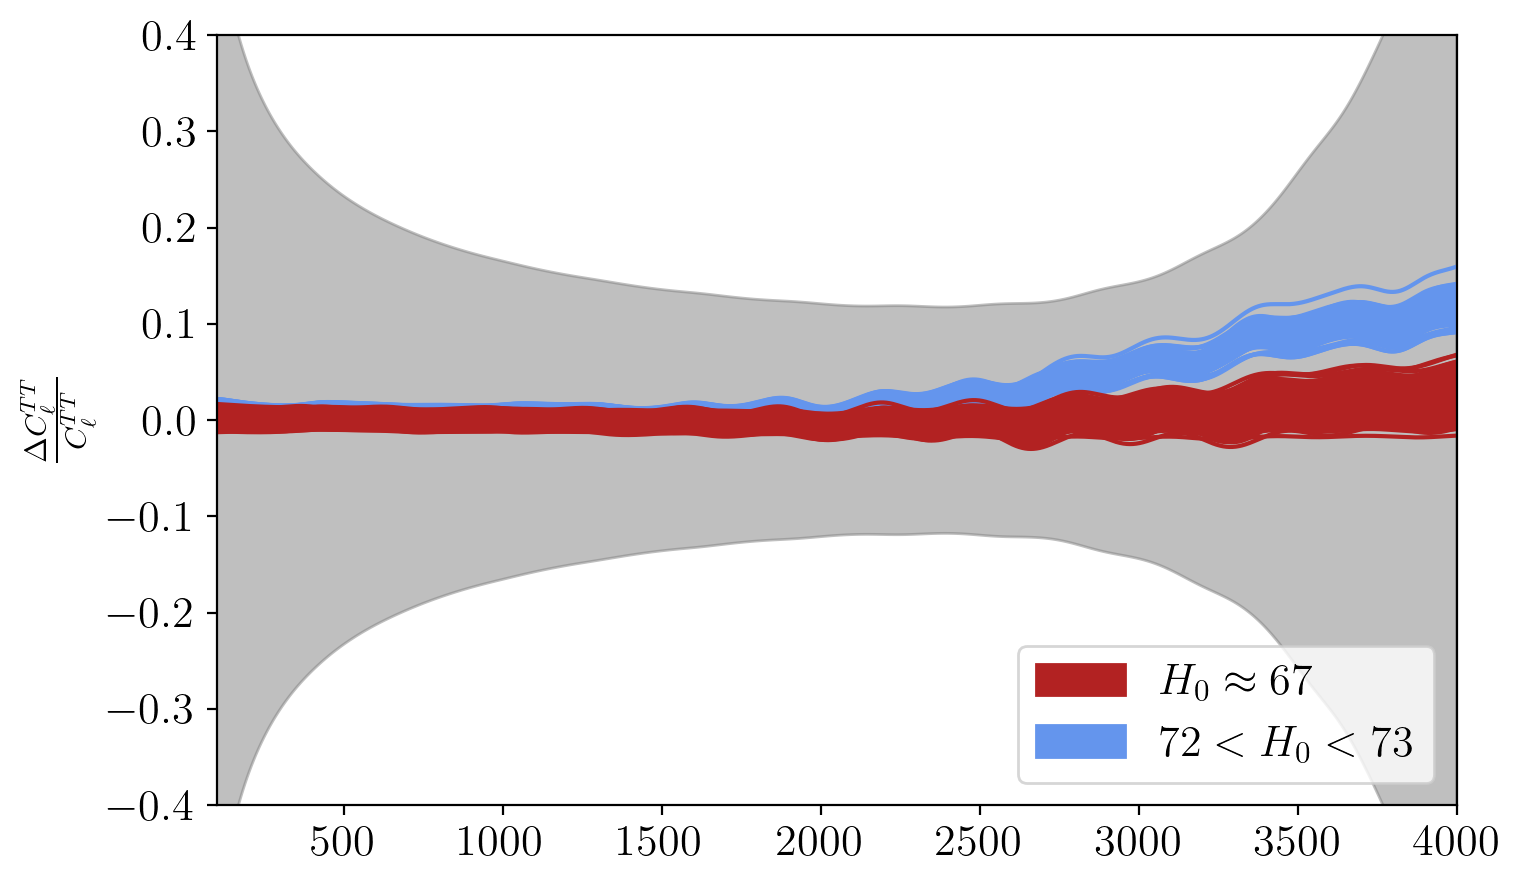

In [ ]:
fig,ax = plt.subplots(figsize=(8,5))

for i in high_H0_ind:
    ax.plot(ll, (tt_high_dict[i]-tt_fid)/tt_fid, color=high_H0_color)
    ax.set_ylabel("$\\frac{\Delta C_\ell^{TT}}{C_\ell^{TT}}$")

for i in low_H0_ind:
    ax.plot(ll, (tt_low_dict[i]-tt_fid)/tt_fid, color=low_H0_color)

ax.fill_between(ll, -error_bar_3G_tt/tt_fid, error_bar_3G_tt/tt_fid, alpha=0.5, color="gray")

patch68 = mpatches.Patch(color=low_H0_color, label='$H_0 \\approx 67$')
patch95 = mpatches.Patch(color=high_H0_color, label='$72 < H_0 < 73$')
ax.legend(handles=[patch68, patch95], loc="lower right")

ax.set_ylim([-0.4, 0.4])
ax.set_xlim([100, 4000])

plt.show()
#plt.savefig("../results/ee_residuals_3G_error.png",dpi=300, bbox_inches='tight')

# EE error bars

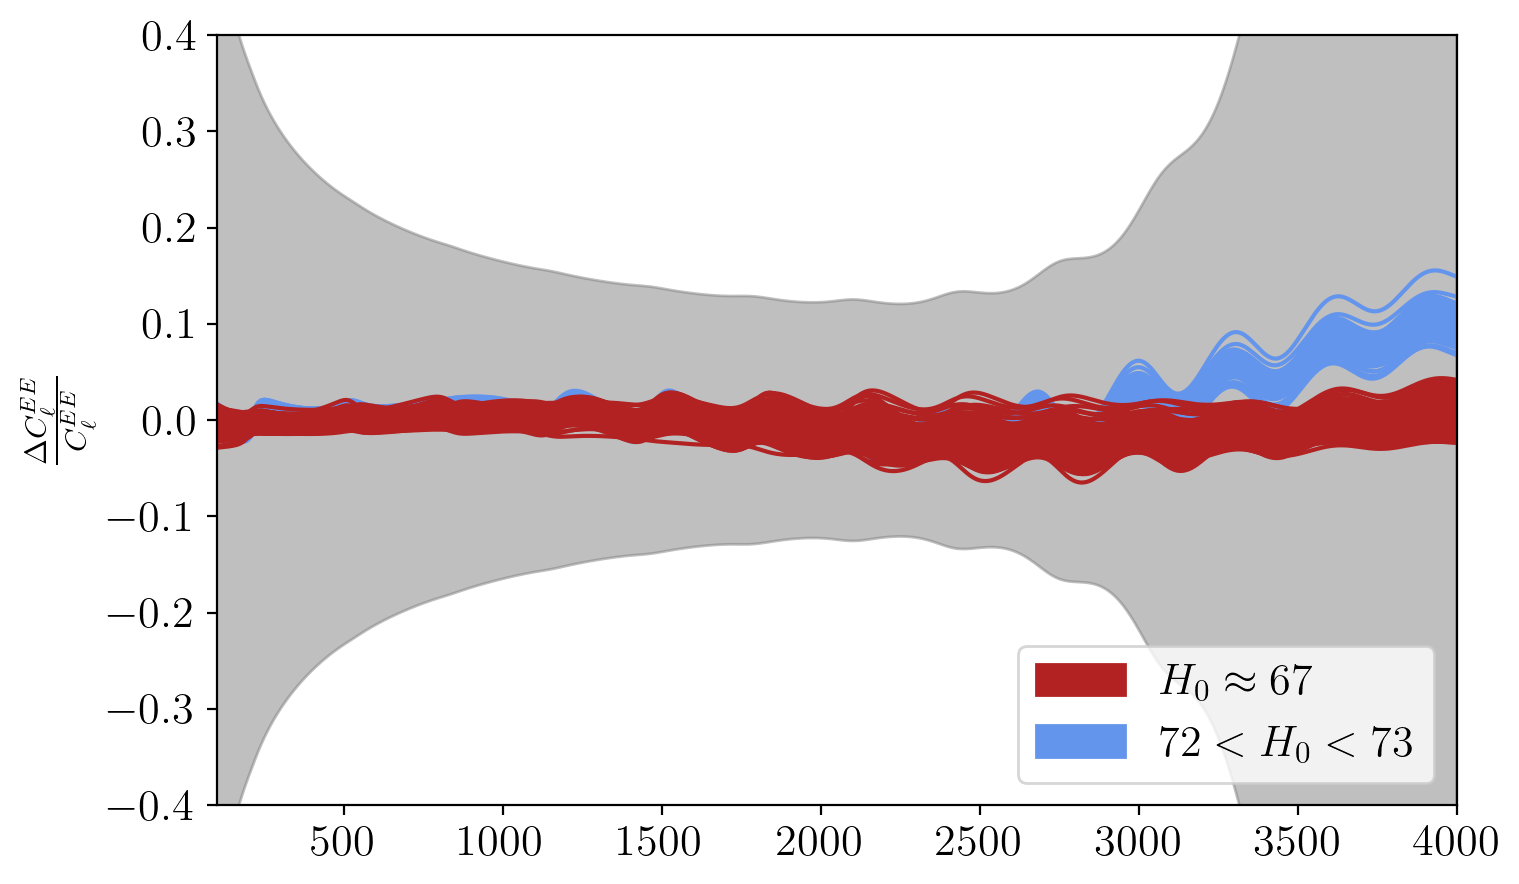

In [ ]:
fig,ax = plt.subplots(figsize=(8,5))

for i in high_H0_ind:
    ax.plot(ll, (ee_high_dict[i]-ee_fid)/ee_fid, color=high_H0_color)
    ax.set_ylabel("$\\frac{\Delta C_\ell^{EE}}{C_\ell^{EE}}$")

for i in low_H0_ind:
    ax.plot(ll, (ee_low_dict[i]-ee_fid)/ee_fid, color=low_H0_color)

ax.fill_between(ll, -error_bar_3G_ee/ee_fid, error_bar_3G_ee/ee_fid, alpha=0.5, color="gray")

patch68 = mpatches.Patch(color=low_H0_color, label='$H_0 \\approx 67$')
patch95 = mpatches.Patch(color=high_H0_color, label='$72 < H_0 < 73$')
ax.legend(handles=[patch68, patch95], loc="lower right")

ax.set_ylim([-0.4, 0.4])
ax.set_xlim([100, 4000])

plt.show()
#plt.savefig("../results/ee_residuals_3G_error.png",dpi=300, bbox_inches='tight')

# TE error bars

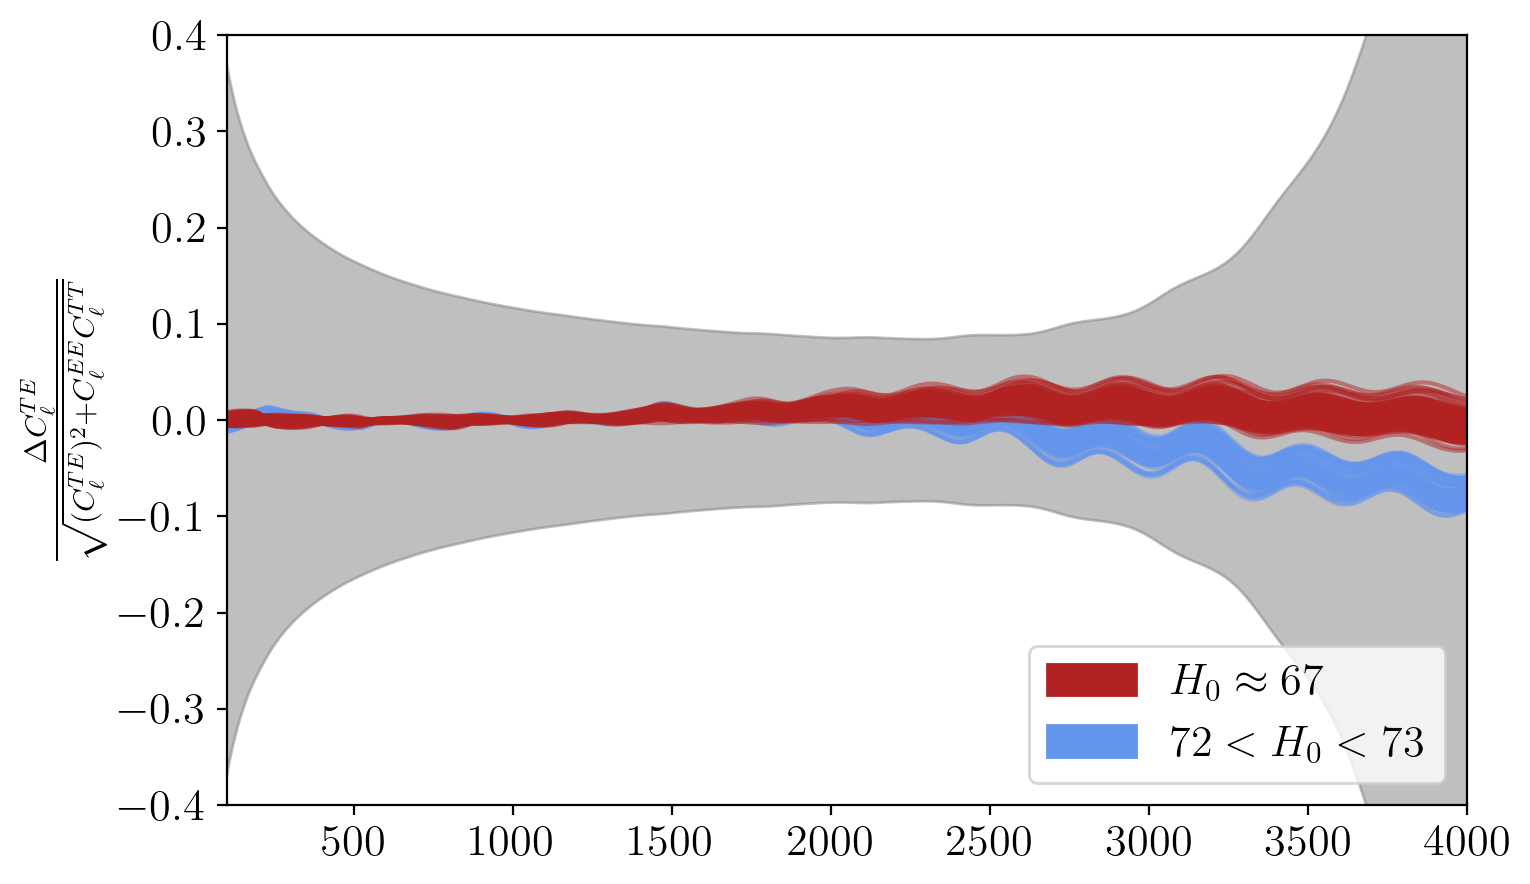

In [ ]:
fig,ax = plt.subplots(figsize=(8,5))

ref = np.sqrt(te_fid**2 + ee_fid*tt_fid)

for i in high_H0_ind:
    ax.plot(ll, (te_high_dict[i]-te_fid)/ref, color=high_H0_color, alpha=0.5)
    ax.set_ylabel("$\\frac{\Delta C_\ell^{TE}}{\sqrt{(C_\ell^{TE})^2 + C_\ell^{EE} C_\ell^{TT}} }$")

for i in low_H0_ind:
    ax.plot(ll, (te_low_dict[i]-te_fid)/ref, color=low_H0_color, alpha=0.5)

ax.fill_between(ll, -error_bar_3G_te/ref, error_bar_3G_te/ref, alpha=0.5, color="gray")

patch68 = mpatches.Patch(color=low_H0_color, label='$H_0 \\approx 67$')
patch95 = mpatches.Patch(color=high_H0_color, label='$72 < H_0 < 73$')
ax.legend(handles=[patch68, patch95], loc="lower right")

ax.set_ylim([-0.4, 0.4])
ax.set_xlim([100, 4000])


plt.show()
#plt.savefig("../results/ee_residuals_3G_error.png",dpi=300, bbox_inches='tight')

# Binned

## TT

(75.0, 4000.0)

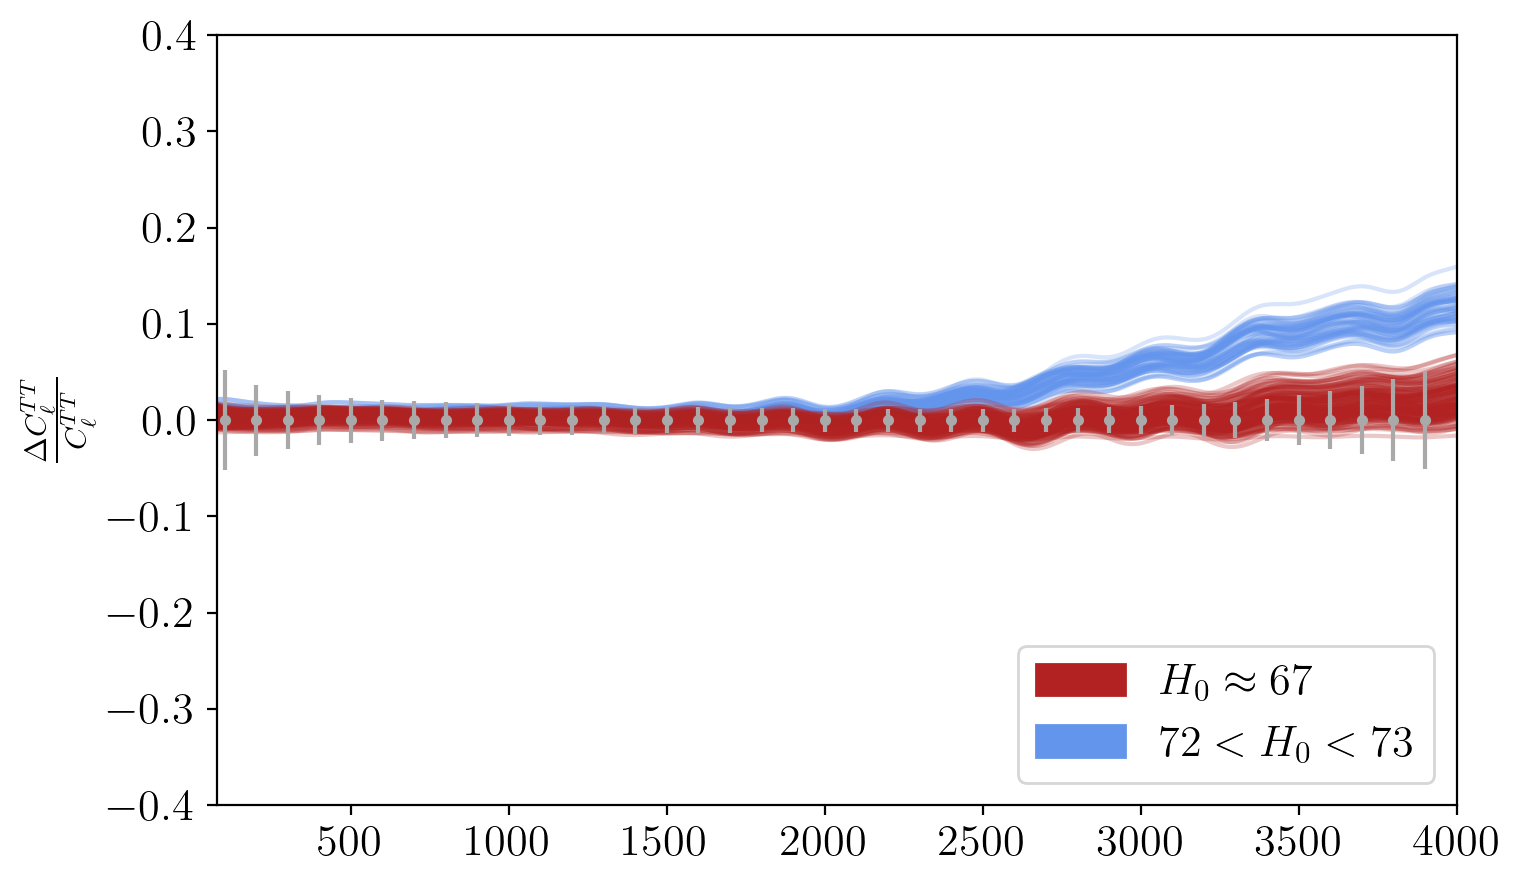

In [ ]:
fig,ax = plt.subplots(figsize=(8,5))

for i in high_H0_ind:
    ax.plot(ll, (tt_high_dict[i]-tt_fid)/tt_fid, color=high_H0_color, alpha=0.25)
    ax.set_ylabel("$\\frac{\Delta C_\ell^{TT}}{C_\ell^{TT}}$")
   #ax.set_ylabel("$\Delta C_\ell^{EE}$")

for i in low_H0_ind:
    ax.plot(ll, (tt_low_dict[i]-tt_fid)/tt_fid, color=low_H0_color, alpha=0.25)

x_values = np.arange(100, 4000, 100)
y_values = np.zeros(x_values.shape)

ax.errorbar(x_values, y_values, yerr=error_bar_3G_tt[x_values-2]/tt_fid[x_values-2]/10, fmt=".", color="darkgray")

patch68 = mpatches.Patch(color=low_H0_color, label='$H_0 \\approx 67$')
patch95 = mpatches.Patch(color=high_H0_color, label='$72 < H_0 < 73$')
ax.legend(handles=[patch68, patch95], loc="lower right")

#ax.set_ylim([-5e-8, 5e-8])
ax.set_ylim([-0.4, 0.4])
ax.set_xlim([75, 4000])

## TE

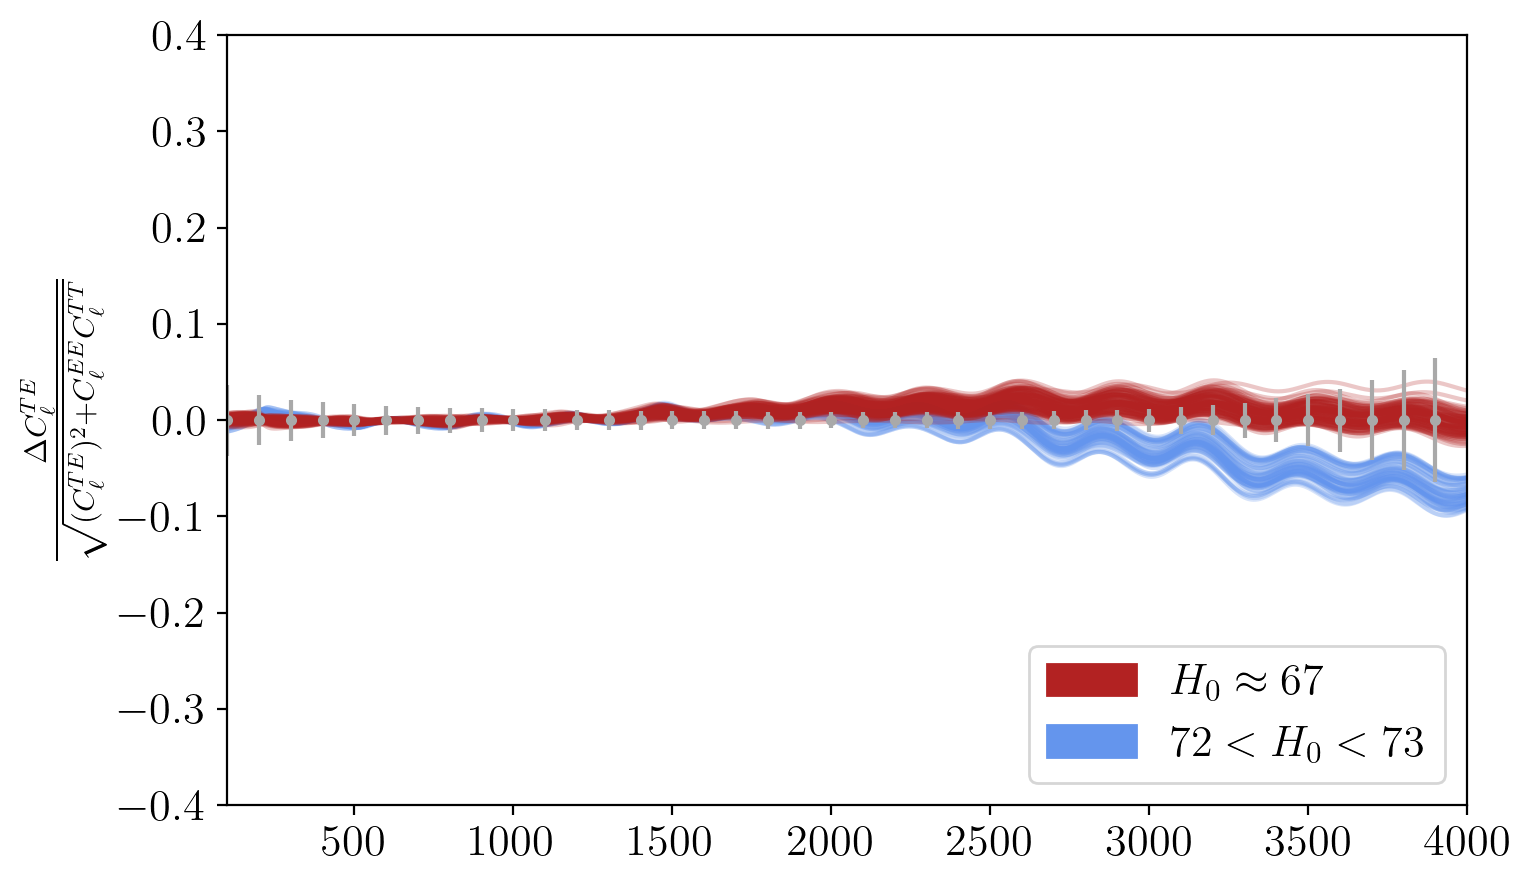

In [ ]:
fig,ax = plt.subplots(figsize=(8,5))

ref = np.sqrt(te_fid**2 + ee_fid*tt_fid)

for i in high_H0_ind:
    ax.plot(ll, (te_high_dict[i]-te_fid)/ref, color=high_H0_color, alpha=0.25)
    ax.set_ylabel("$\\frac{\Delta C_\ell^{TE}}{\sqrt{(C_\ell^{TE})^2 + C_\ell^{EE} C_\ell^{TT}} }$")

for i in low_H0_ind:
    ax.plot(ll, (te_low_dict[i]-te_fid)/ref, color=low_H0_color, alpha=0.25)

x_values = np.arange(100, 4000, 100)
y_values = np.zeros(x_values.shape)

ax.errorbar(x_values, y_values, yerr=error_bar_3G_te[x_values-2]/ref[x_values-2]/10, fmt=".", color="darkgray")

patch68 = mpatches.Patch(color=low_H0_color, label='$H_0 \\approx 67$')
patch95 = mpatches.Patch(color=high_H0_color, label='$72 < H_0 < 73$')
ax.legend(handles=[patch68, patch95], loc="lower right")

ax.set_ylim([-0.4, 0.4])
ax.set_xlim([100, 4000])

plt.show()

## EE

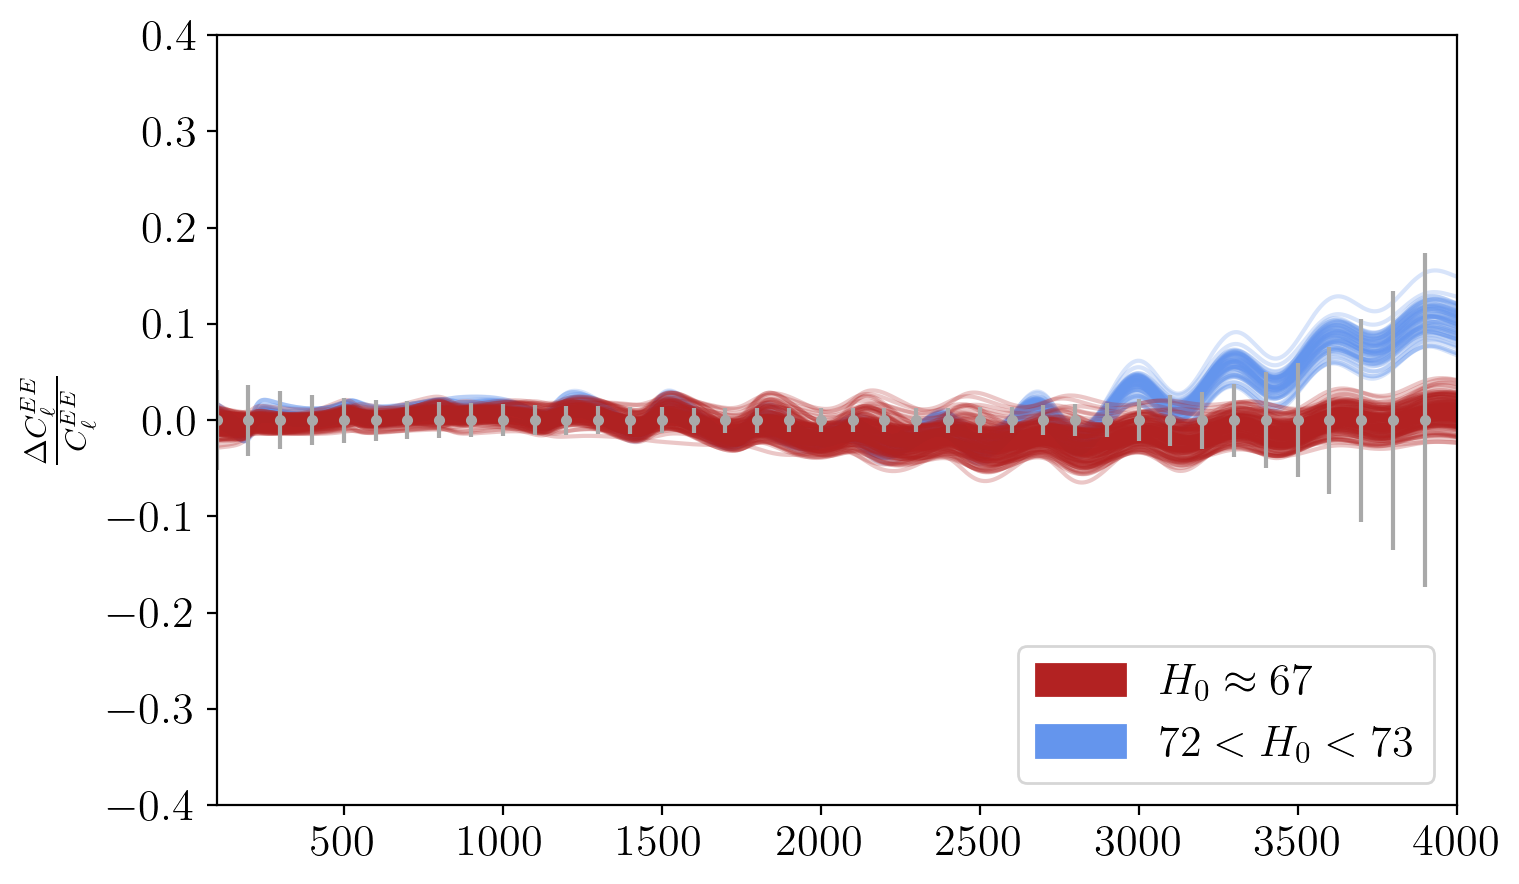

In [ ]:
fig,ax = plt.subplots(figsize=(8,5))

for i in high_H0_ind:
    ax.plot(ll, (ee_high_dict[i]-ee_fid)/ee_fid, color=high_H0_color, alpha=0.25)
    ax.set_ylabel("$\\frac{\Delta C_\ell^{EE}}{C_\ell^{EE}}$")

for i in low_H0_ind:
    ax.plot(ll, (ee_low_dict[i]-ee_fid)/ee_fid, color=low_H0_color, alpha=0.25)

x_values = np.arange(100, 4000, 100)
y_values = np.zeros(x_values.shape)

ax.errorbar(x_values, y_values, yerr=error_bar_3G_ee[x_values-2]/ee_fid[x_values-2]/10, fmt=".", color="darkgray")

patch68 = mpatches.Patch(color=low_H0_color, label='$H_0 \\approx 67$')
patch95 = mpatches.Patch(color=high_H0_color, label='$72 < H_0 < 73$')
ax.legend(handles=[patch68, patch95], loc="lower right")

ax.set_ylim([-0.4, 0.4])
ax.set_xlim([100, 4000])

plt.show()

# Plotting with data points overlaid

## Loading data

In [ ]:
######################################################
# SPT 3G data 
######################################################

spt3g_data = np.loadtxt("../data/SPT3G_2018_TTTEEE_MV_bdp.txt")
spt3g_tt = {}
spt3g_tt["ell"] = spt3g_data[9:, 2]
spt3g_tt_Dl = spt3g_data[9:, 3]
spt3g_tt_error = spt3g_data[9:, 4]

spt3g_tt["cl"] = (2*np.pi)/(spt3g_tt["ell"]*(spt3g_tt["ell"]+1))*spt3g_tt_Dl
spt3g_tt["sigma"] = (2*np.pi)/(spt3g_tt["ell"]*(spt3g_tt["ell"]+1))*spt3g_tt_error

spt3g_te = {}
spt3g_te["ell"] = spt3g_data[:, 5]
spt3g_te_Dl = spt3g_data[:, 6]
spt3g_te_error = spt3g_data[:, 7]

spt3g_te["cl"] = (2*np.pi)/(spt3g_te["ell"]*(spt3g_te["ell"]+1))*spt3g_te_Dl
spt3g_te["sigma"] = (2*np.pi)/(spt3g_te["ell"]*(spt3g_te["ell"]+1))*spt3g_te_error

spt3g_ee = {}
spt3g_ee["ell"] = spt3g_data[:, 8]
spt3g_ee_Dl = spt3g_data[:, 9]
spt3g_ee_error = spt3g_data[:, 10]
spt3g_ee["cl"] = (2*np.pi)/(spt3g_ee["ell"]*(spt3g_ee["ell"]+1))*spt3g_ee_Dl
spt3g_ee["sigma"] = (2*np.pi)/(spt3g_ee["ell"]*(spt3g_ee["ell"]+1))*spt3g_ee_error

spt3g = {}
spt3g["tt"] = spt3g_tt
spt3g["te"] = spt3g_te
spt3g["ee"] = spt3g_ee

######################################################
# Planck data
######################################################

planck_data_tt = np.loadtxt("/Users/gabe/projects/recombination/data/planck/COM_PowerSpect_CMB-TT-binned_R3.01.txt")

planck_tt = {}
planck_tt_error = np.vstack([planck_data_tt[:,2], planck_data_tt[:,3]])
planck_tt["ell"] = planck_data_tt[:,0]
planck_tt_Dl = planck_data_tt[:,1]

planck_tt["cl"] = 2*np.pi/(planck_tt["ell"]*(planck_tt["ell"]+1)) * planck_tt_Dl
planck_tt["sigma"] = 2*np.pi/(planck_tt["ell"]*(planck_tt["ell"]+1)) * planck_tt_error

planck_data_te = np.loadtxt("/Users/gabe/projects/recombination/data/planck/COM_PowerSpect_CMB-TE-binned_R3.02.txt")

planck_te = {}
planck_te_error = np.vstack([planck_data_te[:,2], planck_data_te[:,3]])
planck_te["ell"] = planck_data_te[:,0]
planck_te_Dl = planck_data_te[:,1]

planck_te["cl"] = 2*np.pi/(planck_te["ell"]*(planck_te["ell"]+1)) * planck_te_Dl
planck_te["sigma"] = 2*np.pi/(planck_te["ell"]*(planck_te["ell"]+1)) * planck_te_error

planck_data_ee = np.loadtxt("/Users/gabe/projects/recombination/data/planck/COM_PowerSpect_CMB-EE-binned_R3.02.txt")

planck_ee = {}
planck_ee_error = np.vstack([planck_data_ee[:,2], planck_data_ee[:,3]])
planck_ee["ell"] = planck_data_ee[:,0]
planck_ee_Dl = planck_data_ee[:,1]

planck_ee["cl"] = 2*np.pi/(planck_ee["ell"]*(planck_ee["ell"]+1)) * planck_ee_Dl
planck_ee["sigma"] = 2*np.pi/(planck_ee["ell"]*(planck_ee["ell"]+1)) * planck_ee_error

planck = {}
planck["tt"] = planck_tt
planck["te"] = planck_te
planck["ee"] = planck_ee

## TT

(100.0, 4000.0)

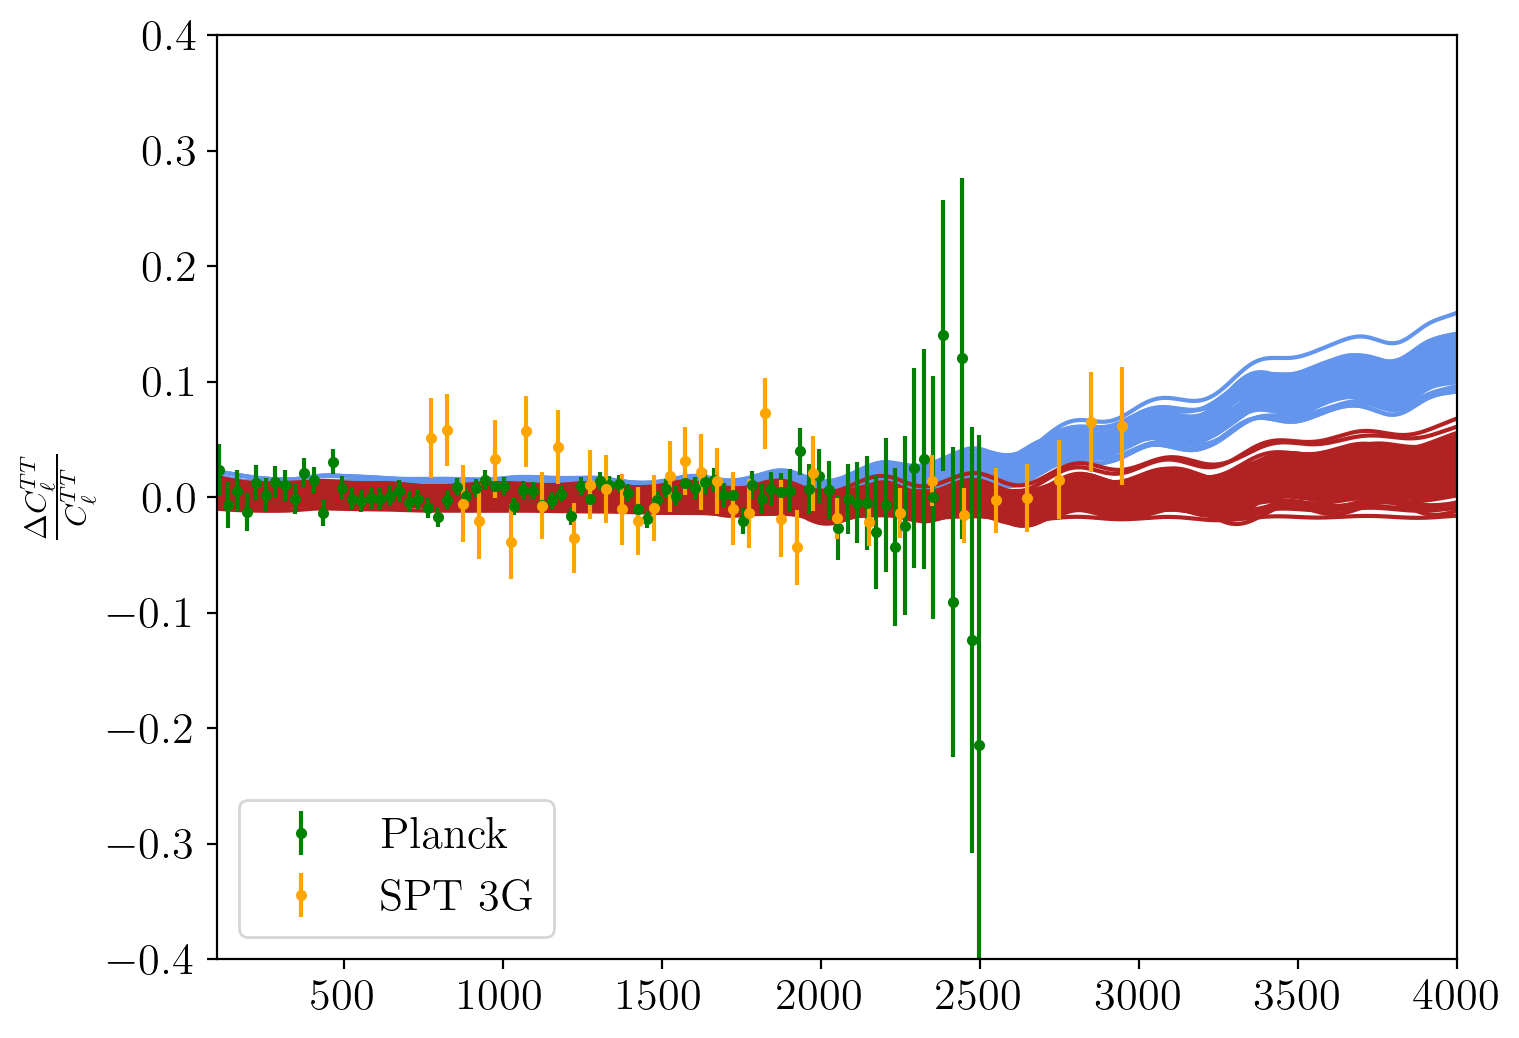

In [ ]:
from scipy.interpolate import interp1d

tt_fid_int = interp1d(ll, tt_fid)

fig,ax = plt.subplots()

for i in high_H0_ind:
    ax.plot(ll, (tt_high_dict[i]-tt_fid)/tt_fid, color=high_H0_color)
    ax.set_ylabel("$\\frac{\Delta C_\ell^{TT}}{C_\ell^{TT}}$")

for i in low_H0_ind:
    ax.plot(ll, (tt_low_dict[i]-tt_fid)/tt_fid, color=low_H0_color)

ax.errorbar(planck["tt"]["ell"], (planck["tt"]["cl"]-tt_fid_int(planck["tt"]["ell"]))/tt_fid_int(planck["tt"]["ell"]), yerr=planck["tt"]["sigma"]/tt_fid_int(planck["tt"]["ell"]), fmt=".", label="Planck", color="green")
ax.errorbar(spt3g["tt"]["ell"], (spt3g["tt"]["cl"]-tt_fid_int(spt3g["tt"]["ell"]))/tt_fid_int(spt3g["tt"]["ell"]), yerr=spt3g["tt"]["sigma"]/tt_fid_int(spt3g["tt"]["ell"]), fmt=".", label="SPT 3G", color="orange")
ax.legend(loc="lower left")
ax.set_ylim([-0.4, 0.4])
ax.set_xlim([100, 4000])

## TE

(100.0, 4000.0)

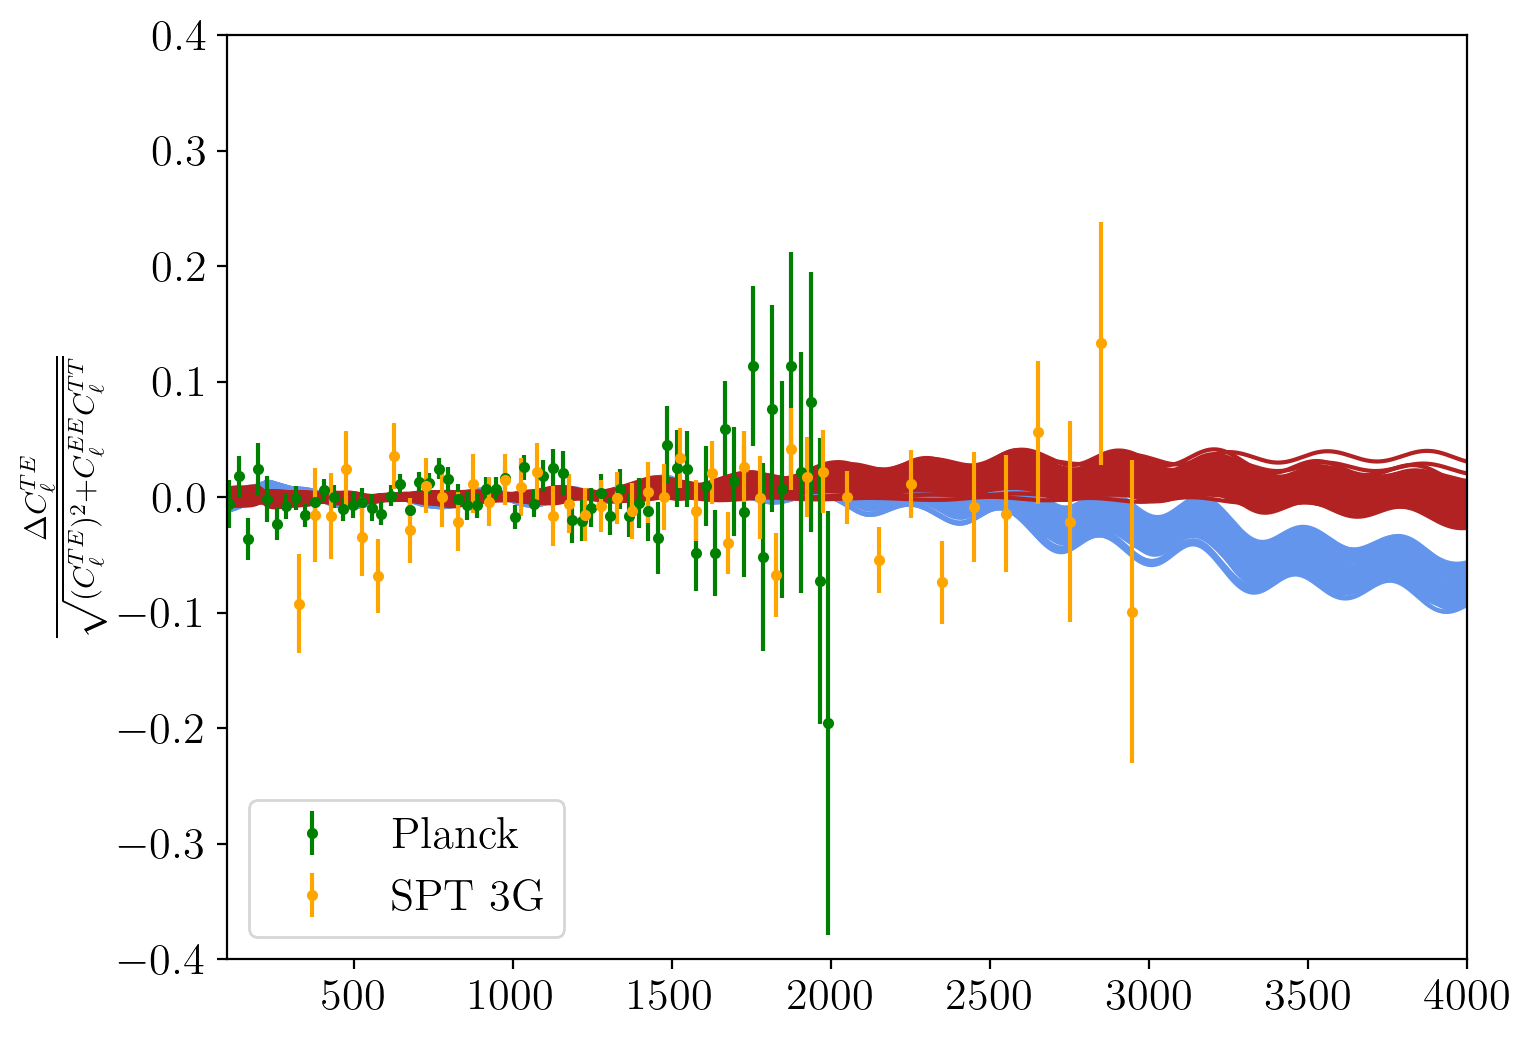

In [ ]:
te_fid_int = interp1d(ll, te_fid)
ee_fid_int = interp1d(ll, ee_fid)


fig,ax = plt.subplots()

ref_planck = np.sqrt(te_fid_int(planck["te"]["ell"])**2 + ee_fid_int(planck["te"]["ell"])*tt_fid_int(planck["te"]["ell"]))
ref_spt3g = np.sqrt(te_fid_int(spt3g["te"]["ell"])**2 + ee_fid_int(spt3g["te"]["ell"])*tt_fid_int(spt3g["te"]["ell"]))
ref = np.sqrt(te_fid**2 + ee_fid*tt_fid)

for i in high_H0_ind:
    ax.plot(ll, (te_high_dict[i]-te_fid)/ref, color=high_H0_color)
    ax.set_ylabel("$\\frac{\Delta C_\ell^{TE}}{\sqrt{(C_\ell^{TE})^2 + C_\ell^{EE} C_\ell^{TT}} }$")

for i in low_H0_ind:
    ax.plot(ll, (te_low_dict[i]-te_fid)/ref, color=low_H0_color)

ax.errorbar(planck["te"]["ell"], (planck["te"]["cl"]-te_fid_int(planck["te"]["ell"]))/ref_planck, yerr=planck["te"]["sigma"]/ref_planck, fmt=".", label="Planck", color="green")
ax.errorbar(spt3g["te"]["ell"], (spt3g["te"]["cl"]-te_fid_int(spt3g["te"]["ell"]))/ref_spt3g, yerr=spt3g["te"]["sigma"]/ref_spt3g, fmt=".", label="SPT 3G", color="orange")
ax.legend(loc="lower left")
ax.set_ylim([-0.4, 0.4])
ax.set_xlim([100, 4000])

(100.0, 4000.0)

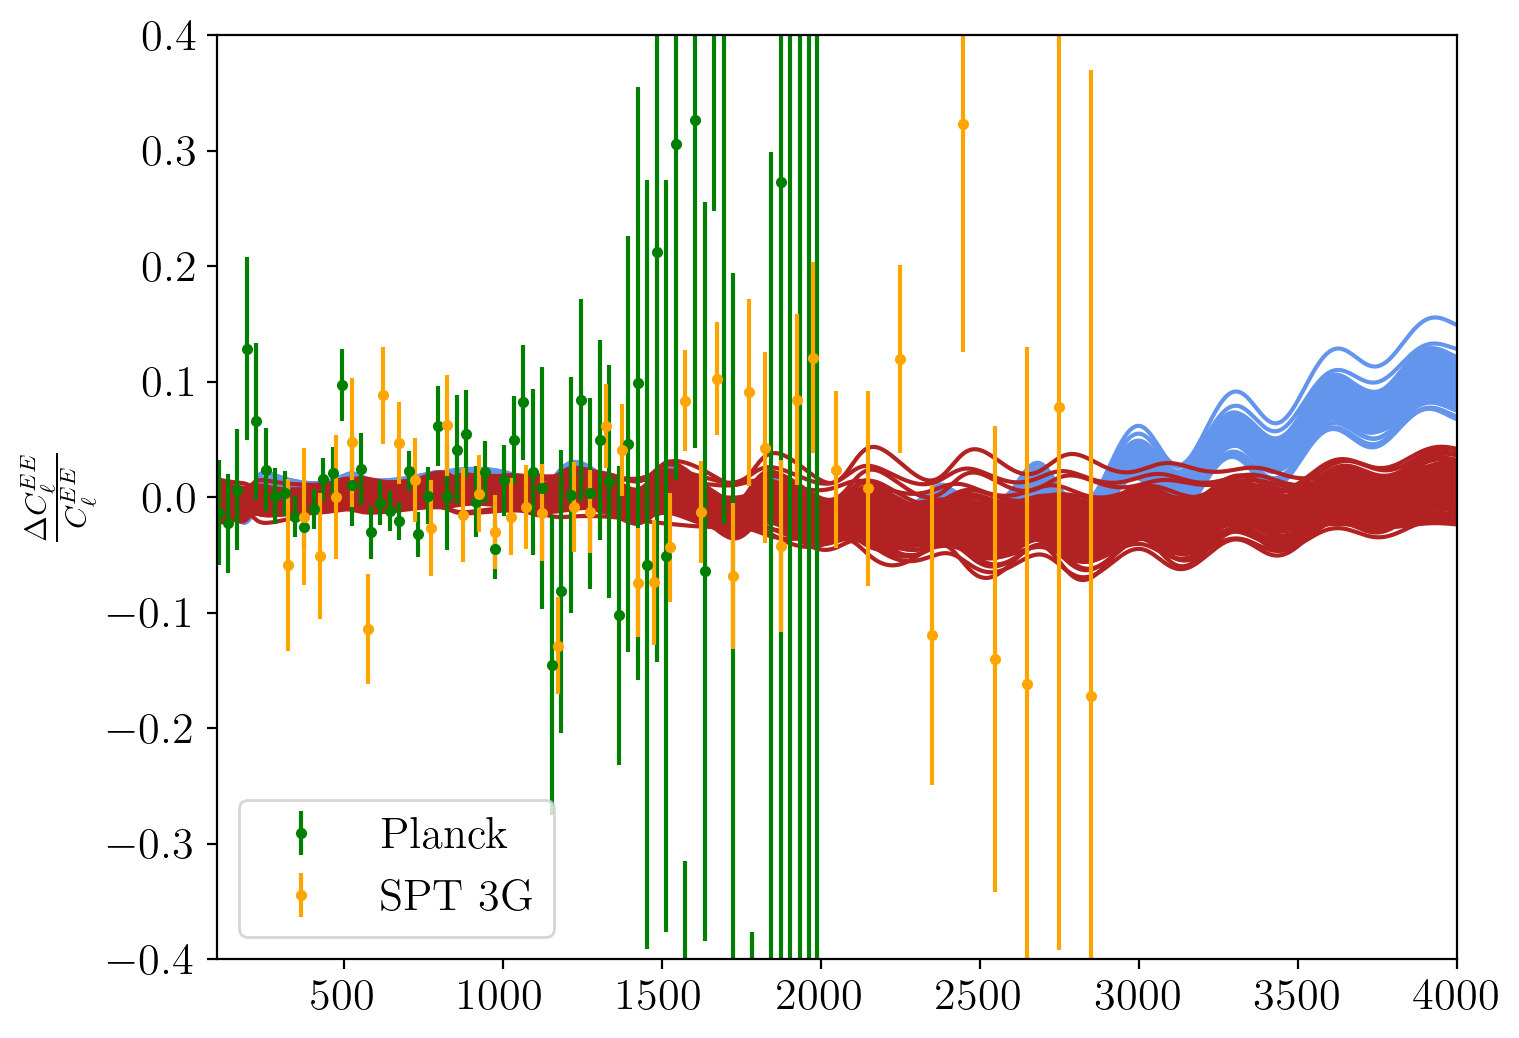

In [ ]:
fig,ax = plt.subplots()

for i in high_H0_ind:
    ax.plot(ll, (ee_high_dict[i]-ee_fid)/ee_fid, color=high_H0_color)
    ax.set_ylabel("$\\frac{\Delta C_\ell^{EE}}{C_\ell^{EE}}$")

for i in low_H0_ind:
    ax.plot(ll, (ee_low_dict[i]-ee_fid)/ee_fid, color=low_H0_color)

ax.errorbar(planck["ee"]["ell"], (planck["ee"]["cl"]-ee_fid_int(planck["ee"]["ell"]))/ee_fid_int(planck["ee"]["ell"]), yerr=planck["ee"]["sigma"]/ee_fid_int(planck["ee"]["ell"]), fmt=".", label="Planck", color="green")
ax.errorbar(spt3g["ee"]["ell"], (spt3g["ee"]["cl"]-ee_fid_int(spt3g["ee"]["ell"]))/ee_fid_int(spt3g["ee"]["ell"]), yerr=spt3g["ee"]["sigma"]/ee_fid_int(spt3g["ee"]["ell"]), fmt=".", label="SPT 3G", color="orange")
ax.legend(loc="lower left")
ax.set_ylim([-0.4, 0.4])
ax.set_xlim([100, 4000])

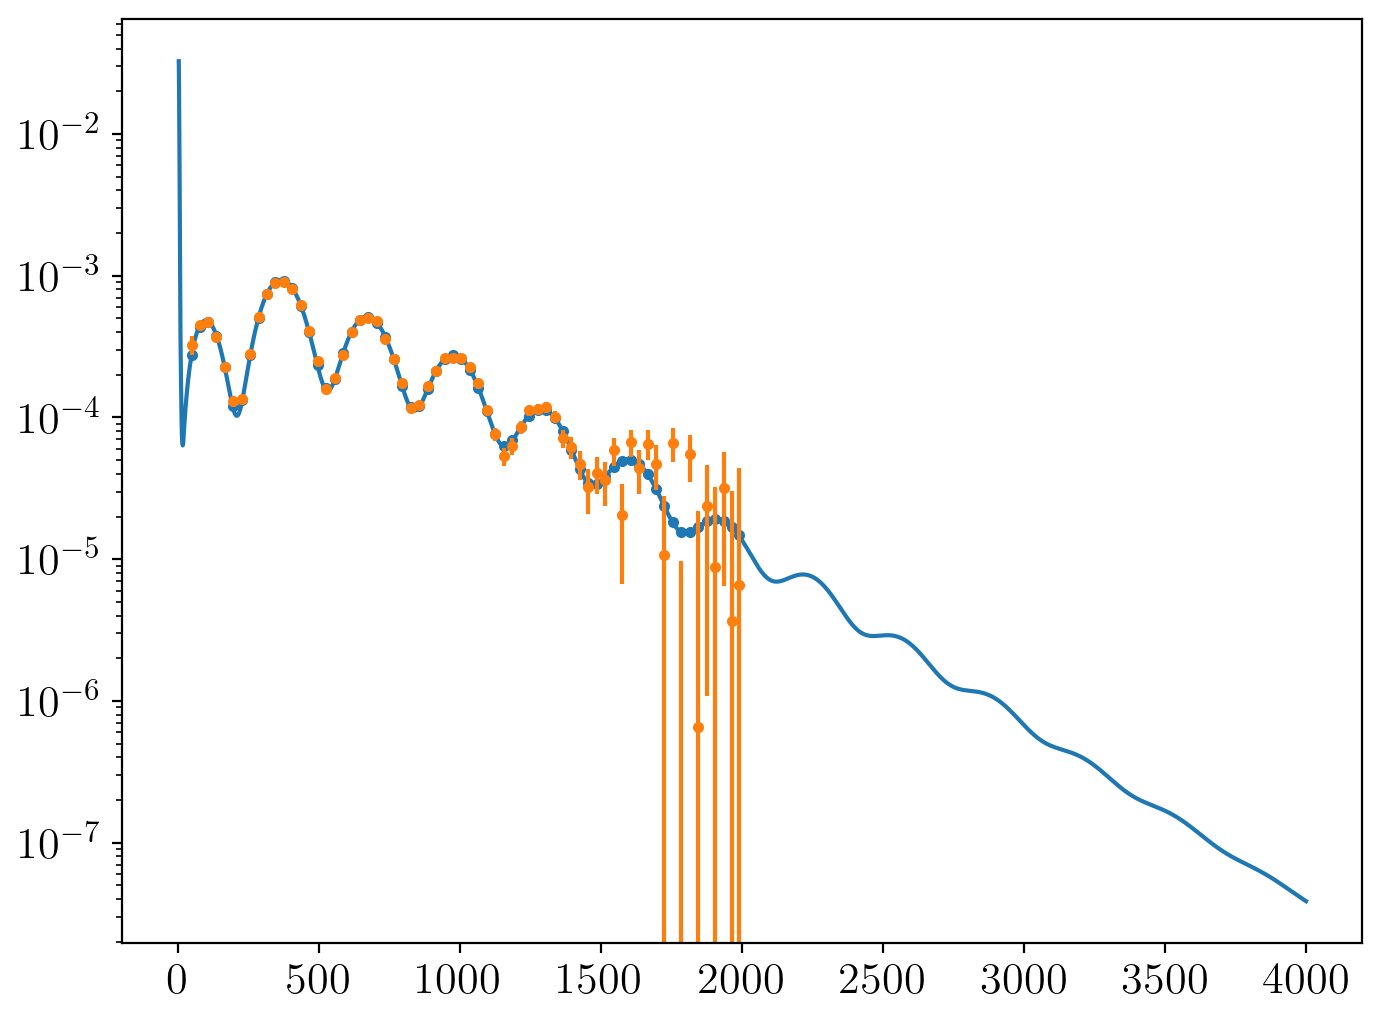

In [ ]:
fig,ax = plt.subplots()

ax.plot(ll, ee_fid)
ax.errorbar(planck["ee"]["ell"], planck["ee"]["cl"], yerr=planck["ee"]["sigma"], fmt=".")
ax.scatter(planck_data_ee[:,0], (2*np.pi)/(planck_data_ee[:,0]*(planck_data_ee[:,0]+1))*planck_data_ee[:, 4], marker=".")
ax.set_yscale('log')

(75.0, 4000.0)

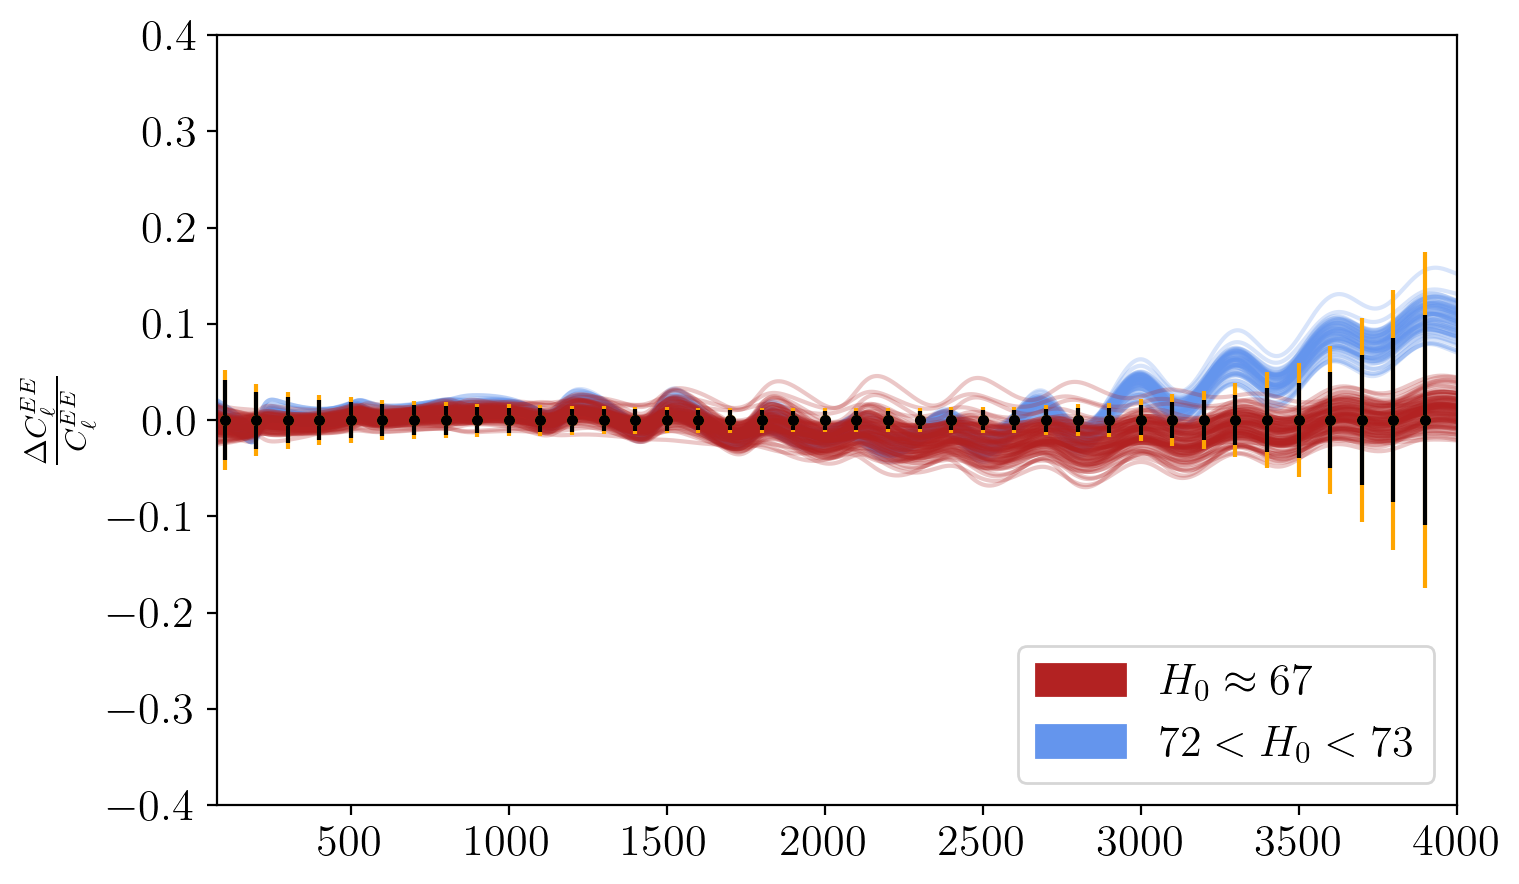

In [ ]:
fig,ax = plt.subplots(figsize=(8,5))

ref_model=ee_fid

for i in high_H0_ind:
    ax.plot(ll, (ee_high_dict[i]-ee_fid)/ref_model, color=high_H0_color, alpha=0.25)
    ax.set_ylabel("$\\frac{\Delta C_\ell^{EE}}{C_\ell^{EE}}$")
   #ax.set_ylabel("$\Delta C_\ell^{EE}$")

for i in low_H0_ind:
    ax.plot(ll, (ee_low_dict[i]-ee_fid)/ref_model, color=low_H0_color, alpha=0.25)

tobs = 1
field = 100 #square degrees
skyarea = 41252.96125
fsky_smallfield = field/skyarea
ilc_Nl_smallfield = ilc_Nl*(6/tobs)*(field/1500)
error_bar_3G_smallfield = np.sqrt(2/(fsky_smallfield*(2*ll+1)))*(ee_fid + ilc_Nl_smallfield)

error_bar_3G_combined = 1.0/(1.0/error_bar_3G + 1.0/error_bar_3G_smallfield)

x_values = np.arange(100, 4000, 100)
y_values = np.zeros(x_values.shape)

ax.errorbar(x_values, y_values, yerr=error_bar_3G[x_values-2]/ref_model[x_values-1]/10, fmt=".", color="orange")
ax.errorbar(x_values, y_values, yerr=error_bar_3G_combined[x_values-2]/ref_model[x_values-1]/10, fmt=".", color="black")

patch68 = mpatches.Patch(color=low_H0_color, label='$H_0 \\approx 67$')
patch95 = mpatches.Patch(color=high_H0_color, label='$72 < H_0 < 73$')
ax.legend(handles=[patch68, patch95], loc="lower right")

#ax.set_ylim([-5e-8, 5e-8])
ax.set_ylim([-0.4, 0.4])
ax.set_xlim([75, 4000])

(75.0, 4000.0)

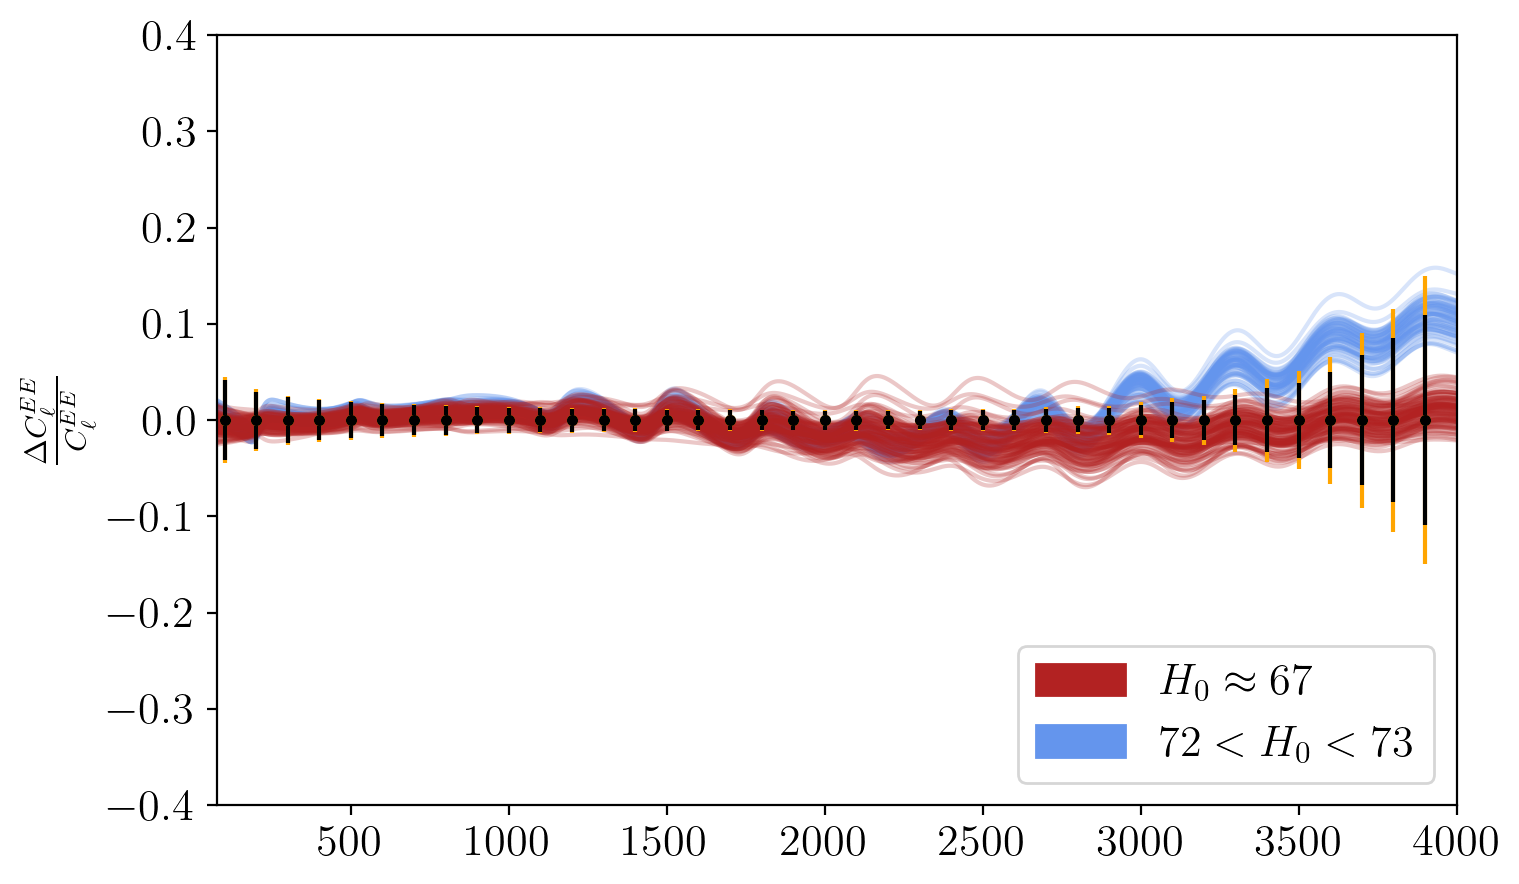

In [ ]:
fig,ax = plt.subplots(figsize=(8,5))

ref_model=ee_fid

for i in high_H0_ind:
    ax.plot(ll, (ee_high_dict[i]-ee_fid)/ref_model, color=high_H0_color, alpha=0.25)
    ax.set_ylabel("$\\frac{\Delta C_\ell^{EE}}{C_\ell^{EE}}$")
   #ax.set_ylabel("$\Delta C_\ell^{EE}$")

for i in low_H0_ind:
    ax.plot(ll, (ee_low_dict[i]-ee_fid)/ref_model, color=low_H0_color, alpha=0.25)

error_bar_3G_7yr = error_bar_3G*(6./7)

x_values = np.arange(100, 4000, 100)
y_values = np.zeros(x_values.shape)

ax.errorbar(x_values, y_values, yerr=error_bar_3G_7yr[x_values-2]/ref_model[x_values-1]/10, fmt=".", color="orange")
ax.errorbar(x_values, y_values, yerr=error_bar_3G_combined[x_values-2]/ref_model[x_values-1]/10, fmt=".", color="black")

patch68 = mpatches.Patch(color=low_H0_color, label='$H_0 \\approx 67$')
patch95 = mpatches.Patch(color=high_H0_color, label='$72 < H_0 < 73$')
ax.legend(handles=[patch68, patch95], loc="lower right")

#ax.set_ylim([-5e-8, 5e-8])
ax.set_ylim([-0.4, 0.4])
ax.set_xlim([75, 4000])